In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv 
import json
import os
import shutil
from pathlib import Path
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
def linear(x, a, b):
    return a * x + b

def linear_regression(inxes, lines):
    ab_s = []

    for line in lines:
        ab, _ = curve_fit(linear, inxes, line)
        #line_fit = ab[0]*inxes+ab[1]
        ab_s.append(ab)

    ab_s = np.array(ab_s)

    return ab_s

In [72]:
def filter_margin(edges, im_length):
    if edges[0] < 20:
        edges = np.delete(edges, 0)
    if edges[-1] > (im_length - 20):
        edges = np.delete(edges, -1)
    
    return edges

In [211]:
def detect_edge(image, peaks_on=0, cell_size=30, split_size=10, im_size=[300, 600], row_col = [8, 16]):
    # 0: x, 1: y
    image_g = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    if peaks_on == 0:
        splits = np.vsplit(image_g, image_g.shape[0]/split_size)
        
    elif peaks_on == 1:
        splits = np.hsplit(image_g, image_g.shape[1]/split_size)
        
    else:
        print('peaks_on must be 0 or 1')
        return 
    
    peaklist = []
    splits_inx = []

    # peaks when suming the whole image
    sum_whole = np.sum(image_g, axis=peaks_on)
    sum_whole = sum_whole/sum_whole.max()
    peaks_whole, _ = find_peaks(-sum_whole, distance=cell_size)
    peaks_whole = filter_margin(peaks_whole, im_length=im_size[peaks_on-1])

    flag = False
    for inx, split in enumerate(splits):
    
        sum_split = np.sum(split, axis=peaks_on)
        sum_split = sum_split/sum_split.max()
        peaks_split, _ = find_peaks(-sum_split, distance=cell_size)
        peaks_split = filter_margin(peaks_split, im_length=im_size[peaks_on-1])

        splits_inx.append(int(split_size * (inx + 1/2)))
        if len(peaks_split) == row_col[peaks_on-1] - 1:
            peaklist.append(peaks_split)
        elif (len(peaks_split) != row_col[peaks_on-1] - 1) and inx != 0: 
            peaklist.append(peaklist[inx-1])
        elif len(peaks_split) == row_col[peaks_on-1] - 1:
            peaklist.append(peaks_whole)
        else:
            peaklist.append('nan')
            flag = True
            
    # use any other splits to represent split[0, 1, 2...] if peaklist[0] fails  
    if flag:
        peaklist = np.array(peaklist)
        nan = np.argwhere(peaklist=='nan')
        n_nan = np.argwhere(peaklist!='nan')
        for i in nan:
            peaklist[int(i)] = peaklist[int(n_nan[0])]
        peaklist = list(peaklist)

    edgelist = np.array(list(zip(*peaklist)))
    edgelist_c = np.copy(edgelist)

    if len(peaks_whole) == row_col[peaks_on-1] - 1: 
        for i, edge in enumerate(edgelist_c):
            for j, sub_edge in enumerate(edge):
                if np.abs(sub_edge - peaks_whole[i]) > 10:
                    edgelist_c[i][j] = peaks_whole[i]

    return np.array(splits_inx), edgelist_c

In [4]:
def displace(line_ab, displacement):
    c = displacement * np.sqrt((1+line_ab[0]**2))

    return (line_ab[0], line_ab[1] + c)

def couple_edges(lines_ab, length, displacement=0, add_edge=True):  # The first line in the tuple moves to negative direction, the second to positive direction
    lines_copy = np.copy(lines_ab)
    if add_edge:
        lines_copy = np.insert(lines_copy, 0, [0,0], axis=0)
        lines_copy = np.insert(lines_copy, len(lines_copy), [0,length-1], axis=0)
    lines_l = np.delete(lines_copy, -1, 0)
    lines_r = np.delete(lines_copy, 0, 0)
    lines_couple = np.array(list(zip(lines_l, lines_r)))

    lines_couple_new = []
    for couple in lines_couple:
        minus = displace(couple[0], -displacement)
        plus = displace(couple[1], displacement)
        lines_couple_new.append((minus, plus))

    return np.array(lines_couple_new)

def cross(vline, hline):
    x = (vline[0]*hline[1]+vline[1]) / (1-vline[0]*hline[0])
    y = (hline[0]*vline[1]+hline[1]) / (1-vline[0]*hline[0])

    return (x, y)

In [5]:
def perspective_transform(image, src, size):
    src = np.float32(src)
    dst = np.float32([(0, 0), (size, 0), (0, size), (size, size)])
    M = cv.getPerspectiveTransform(src, dst)
    
    warped = cv.warpPerspective(image, M, (size, size))
    
    return warped

In [6]:
def segment_cell(image, abs_x_couple, abs_y_couple, saveplace=None, save=False, cellsize=32):

    cells = []
    for i, hline_ab in enumerate(abs_y_couple):
        for j, vline_ab in enumerate(abs_x_couple):
            xy = []
            for hab in hline_ab:
                for vab in vline_ab:
                    xy.append(cross(vab, hab))
            

            warped = perspective_transform(image, xy, cellsize)
            cells.append(warped)

            #counter += 1

            if save:
                cv.imwrite(str(saveplace/(str(i)+str(j)+'.jpg')), warped)
            
    return cells

In [7]:
def coordinate2inx(coordinate, row=8, col=16, im_shape=[300,600]):
    inx = col * round(coordinate[1] / (im_shape[0] / row)) + round(coordinate[0] / (im_shape[1] / col))

    return inx

In [8]:
def classify_cells(ann_path, defects_inx_dic, row_col=[8,16], shape=[300,600]):
    with open(ann_path, 'r') as file:
        data = json.load(file)
    if len(data['objects']) > 0:
        for obj in data['objects']:
            classTitle = obj['classTitle']
            points = obj['points']['exterior'][0]
            inx = coordinate2inx(points, row=row_col[0], col=row_col[1], im_shape=shape)
            defects_inx_dic[classTitle].append(inx)
    
    return defects_inx_dic

In [9]:
def write_cells(single_cells, defects_inx):

    for inx, cell in enumerate(single_cells):
        if inx in defects_inx['crack_bbox']:
            cv.imwrite('classified_cells/crack/'+name+'__'+str(inx)+'.png', cell)
        elif inx in defects_inx['solder_bbox']:
            cv.imwrite('classified_cells/solder/'+name+'__'+str(inx)+'.png', cell)
        elif inx in defects_inx['oxygen_bbox']:
            cv.imwrite('classified_cells/oxygen/'+name+'__'+str(inx)+'.png', cell)
        elif inx in defects_inx['intra_bbox']:
            cv.imwrite('classified_cells/intra/'+name+'__'+str(inx)+'.png', cell)
        else:
            cv.imwrite('classified_cells/intact/'+name+'__'+str(inx)+'.png', cell)

In [10]:
im_dir= Path('./img/')
ann_dir = Path('./ann/')

ann_files = os.listdir(ann_dir)

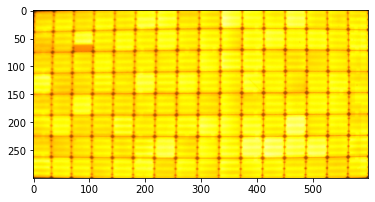

In [234]:
ann_file = ann_files[225]
name = ann_file.split('.')[0]
image = cv.imread(str(im_dir/(name+'.png')))
image_g = cv.imread(str(im_dir/(name+'.png')), 0)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [232]:
splits_inx_x, edgelist_x = detect_edge(image, peaks_on=0)
abs_x = linear_regression(splits_inx_x, edgelist_x)
splits_inx_y, edgelist_y = detect_edge(image, peaks_on=1)
abs_y = linear_regression(splits_inx_y, edgelist_y)

abs_x_couple = couple_edges(abs_x, length=600)
abs_y_couple = couple_edges(abs_y, length=300)

single_cells = segment_cell(image, abs_x_couple, abs_y_couple)

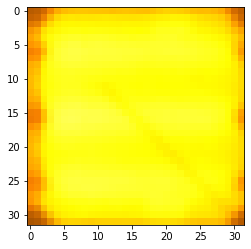

In [246]:
plt.imshow(cv.cvtColor(single_cells[58], cv.COLOR_BGR2RGB))

In [281]:
    defects_dic = {
        'crack_bbox': [],
        'solder_bbox': [],
        'intra_bbox': [],
        'oxygen_bbox': []

    }

In [268]:
for folder in ['crack', 'solder', 'oxygen', 'intra', 'intact']:
    os.makedirs(Path('classified_cells')/folder, exist_ok=True)



In [267]:
defects_inx = classify_cells(ann_dir/ann_file, defects_dic)

In [272]:
len(single_cells)

128

# operate on all the images

In [223]:
for folder in ['crack', 'solder', 'oxygen', 'intra', 'intact']:
    os.makedirs(Path('classified_cells')/folder, exist_ok=True)

N = 0
for ann_file in tqdm(ann_files):
    try:
        name = ann_file.split('.')[0]
        image = cv.imread(str(im_dir/(name+'.png')))
        #image_g = cv.imread(str(im_dir/(name+'.png')), 0)

        splits_inx_x, edgelist_x = detect_edge(image, peaks_on=0)
        abs_x = linear_regression(splits_inx_x, edgelist_x)
        splits_inx_y, edgelist_y = detect_edge(image, peaks_on=1)
        abs_y = linear_regression(splits_inx_y, edgelist_y)

        abs_x_couple = couple_edges(abs_x, length=600)
        abs_y_couple = couple_edges(abs_y, length=300)

        single_cells = segment_cell(image, abs_x_couple, abs_y_couple)
        if len(single_cells) != 128:
            N += 1
            with open('number_error.csv', 'a') as f:
                f.write(name+'\n')
            continue

        defects_dic = {
            'crack_bbox': [],
            'solder_bbox': [],
            'intra_bbox': [],
            'oxygen_bbox': []

        }
        defects_inx = classify_cells(ann_dir/ann_file, defects_dic)
        write_cells(single_cells, defects_inx)
    except:
        N += 1
        with open('script_error.csv', 'a') as f:
                f.write(name+'\n')
print('fail: '+ str(N) + ', ' + str(N/len(ann_files)))

100%|██████████| 905/905 [01:00<00:00, 15.00it/s]fail: 0, 0.0



In [113]:
with open('number_error.csv', 'r') as file:
    data = [line.rstrip() for line in file]

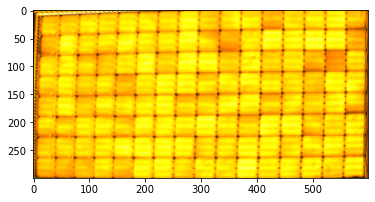

In [224]:
name = data[1]
ann_file = name+'.png.json'
image = cv.imread(str(im_dir/(name+'.png')))
image_g = cv.imread(str(im_dir/(name+'.png')), 0)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [225]:
splits_inx_x, edgelist_x = detect_edge(image, peaks_on=0)
abs_x = linear_regression(splits_inx_x, edgelist_x)
splits_inx_y, edgelist_y = detect_edge(image, peaks_on=1)
abs_y = linear_regression(splits_inx_y, edgelist_y)

len(edgelist_x)

15

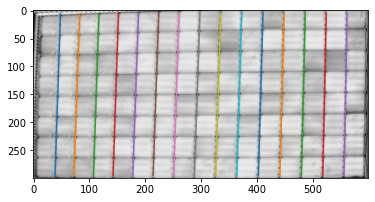

In [227]:
plt.imshow(image_g,'gray')
for abs in abs_x:
    line_fit = abs[0]*splits_inx_x+abs[1]
    plt.plot(line_fit, splits_inx_x)

In [21]:
splits = np.vsplit(image_g, 30)

peaklist = []
splits_inx = []

sum_whole = np.sum(image_g, axis=0)
sum_whole = sum_whole/sum_whole.max()
peaks_whole, _ = find_peaks(-sum_whole, distance=35)

for inx, split in enumerate(splits):

    sum_split = np.sum(split, axis=0)
    sum_split = sum_split/sum_split.max()
    peaks_split, _ = find_peaks(-sum_split, distance=35)

    splits_inx.append(int(10 * (inx + 1/2)))
    if len(peaks_split) == 15:
        peaklist.append(peaks_split)
    else: 
        peaklist.append(peaks_whole)

edgelist = np.array(list(zip(*peaklist)))
edgelist_c = np.copy(edgelist)
"""
sum_whole = np.sum(image_g, axis=peaks_on)
sum_whole = sum_whole/sum_whole.max()
peaks_whole, _ = find_peaks(-sum_whole, distance=cell_size)

for i, edge in enumerate(edgelist_c):
    for j, sub_edge in enumerate(edge):
        if np.abs(sub_edge - peaks_whole[i]) > 10:
            edgelist_c[i][j] = peaks_whole[i]
"""

'\nsum_whole = np.sum(image_g, axis=peaks_on)\nsum_whole = sum_whole/sum_whole.max()\npeaks_whole, _ = find_peaks(-sum_whole, distance=cell_size)\n\nfor i, edge in enumerate(edgelist_c):\n    for j, sub_edge in enumerate(edge):\n        if np.abs(sub_edge - peaks_whole[i]) > 10:\n            edgelist_c[i][j] = peaks_whole[i]\n'

In [22]:
len(edgelist_c)

14

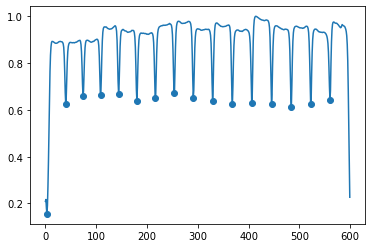

In [210]:
sum_x = np.sum(image_g, axis=0)
sum_x = sum_x/sum_x.max()
peaks_x, _ = find_peaks(-sum_x, distance=30)

plt.plot(list(range(600)), sum_x)
plt.scatter(peaks_x, sum_x[peaks_x])

In [121]:
filter_margin(np.insert(peaks_x, len(peaks_x), 586), 600), np.insert(peaks_x, len(peaks_x), 586)

(array([ 76, 112, 148, 185, 222, 259, 297, 336, 374, 412, 451, 488, 526,
        562]),
 array([  5,  76, 112, 148, 185, 222, 259, 297, 336, 374, 412, 451, 488,
        526, 562, 586]))

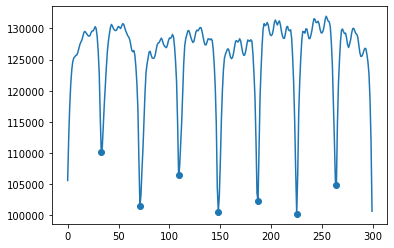

In [59]:
sum_y = np.sum(image_g, axis=1)
peaks_y, _ = find_peaks(-sum_y, distance=35)

plt.plot(list(range(300)), sum_y)
plt.scatter(peaks_y, sum_y[peaks_y])

In [122]:
split_x = np.vsplit(image_g, 30)

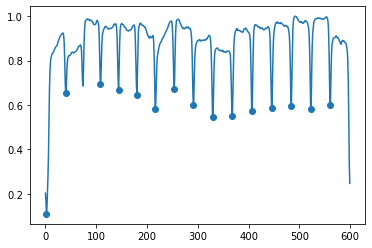

In [204]:
sum_x = np.sum(split_x[10], axis=0)
sum_x = sum_x/sum_x.max()
peaks_x, _ = find_peaks(-sum_x, distance=35)

plt.plot(list(range(600)), sum_x)
plt.scatter(peaks_x, sum_x[peaks_x])

In [102]:
peaklist_x = []
splits_inx = []

for inx, split in enumerate(split_x):

    sum_x = np.sum(split, axis=0)
    sum_x = sum_x/sum_x.max()
    peaks_x, _ = find_peaks(-sum_x, distance=35)

    splits_inx.append(int(300/30 * (inx + 1/2)))

    peaklist_x.append(peaks_x)

edgelist_x = list(zip(*peaklist_x))

In [298]:
splits_inx, edgelist_y = detect_edge(image, peaks_on=1)

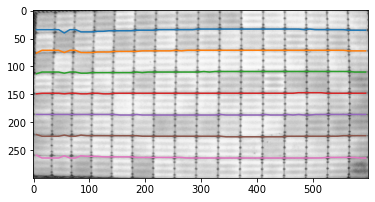

In [299]:
plt.imshow(image_g,'gray')

for edge in edgelist_y:
    plt.plot(splits_inx,edge)

In [296]:
split_y = np.hsplit(image_g, 60)

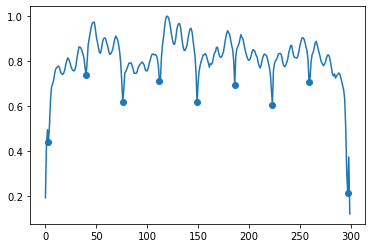

In [300]:
sum_y = np.sum(split_y[2], axis=1)
sum_y = sum_y / sum_y.max()
peaks_y, _ = find_peaks(-sum_y, distance=35)

plt.plot(list(range(300)), sum_y)
plt.scatter(peaks_y, sum_y[peaks_y])